In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import optuna
import shap
import matplotlib.pyplot as plt

## Load data

In [2]:
df = pd.read_csv("../data/train.csv", index_col="PassengerId")

In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

In [4]:
# checking numeric variables
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# checking non-numeric variables, how many distinct values they have
df.describe(include="O")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [6]:
# check how many missing values are there
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [54]:
TARGET = "Survived"
NUM_FEATURES = df.select_dtypes("number").drop(TARGET, axis=1).columns.tolist()
CAT_FEATURES = ["Sex", "Embarked"]
FEATURES = NUM_FEATURES + CAT_FEATURES

In [8]:
df[CAT_FEATURES] = df[CAT_FEATURES].astype("category")

## Split data

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=23)

In [10]:
df_train.shape, df_test.shape

((712, 11), (179, 11))

## Hyperparameter tuning

In [11]:
try:
    study = optuna.load_study(storage="sqlite:///optuna.db")
except:
    study = optuna.create_study(direction="maximize", storage="sqlite:///optuna.db", pruner=optuna.pruners.HyperbandPruner())

[I 2025-01-13 15:38:54,766] A new study created in RDB with name: no-name-5b4f4813-b403-4e83-b8cd-d13960dd4395


In [12]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.00001, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 40),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "verbose": -1,
        "random_state": 23,
    }

    aucs = []
    for i, (train_idx, val_idx) in enumerate(KFold(n_splits=5, random_state=23, shuffle=True).split(df_train)):
        train, val = df.iloc[train_idx], df.iloc[val_idx]

        model = LGBMClassifier(**params)
        model.fit(train[FEATURES], train[TARGET])
        y_pred = model.predict_proba(val[FEATURES])[:, 1]

        auc = roc_auc_score(val[TARGET], y_pred)
        trial.report(auc, i)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        aucs.append(auc)

    return sum(aucs) / len(aucs)

In [14]:
study.optimize(objective, n_trials=100)

[I 2025-01-13 15:39:07,397] Trial 0 finished with value: 0.8338730628035638 and parameters: {'n_estimators': 344, 'learning_rate': 6.295064331354105e-05, 'max_depth': 8, 'num_leaves': 79, 'min_child_samples': 73, 'subsample': 0.2804713085990077, 'colsample_bytree': 0.5009222531466938}. Best is trial 0 with value: 0.8338730628035638.
[I 2025-01-13 15:39:09,853] Trial 1 finished with value: 0.8413487012310213 and parameters: {'n_estimators': 119, 'learning_rate': 0.05563916467500372, 'max_depth': 26, 'num_leaves': 167, 'min_child_samples': 12, 'subsample': 0.9478421518600559, 'colsample_bytree': 0.9412487745181428}. Best is trial 1 with value: 0.8413487012310213.
[I 2025-01-13 15:39:11,062] Trial 2 pruned. 
[I 2025-01-13 15:39:16,991] Trial 3 finished with value: 0.8462025967680897 and parameters: {'n_estimators': 429, 'learning_rate': 0.022498575008046227, 'max_depth': 14, 'num_leaves': 44, 'min_child_samples': 8, 'subsample': 0.8645049850751514, 'colsample_bytree': 0.2794997137633768}.

In [15]:
optuna.visualization.plot_parallel_coordinate(study)

## Train

In [16]:
model = LGBMClassifier(**study.best_params, verbose=-1, random_state=23)

In [17]:
model.fit(df_train[FEATURES], df_train[TARGET])

LGBMClassifier(colsample_bytree=0.4702507579698227,
               learning_rate=0.006699138465008121, max_depth=24,
               min_child_samples=7, n_estimators=282, num_leaves=25,
               random_state=23, subsample=0.9032041349230184, verbose=-1)

## Evaluate

In [18]:
df_train["pred"] = model.predict_proba(df_train[FEATURES])[:, 1]
df_test["pred"] = model.predict_proba(df_test[FEATURES])[:, 1]

In [19]:
roc_auc_score(df_train[TARGET], df_train["pred"]), roc_auc_score(df_test[TARGET], df_test["pred"])

(np.float64(0.946420283128336), np.float64(0.8726902173913044))

## Feature importance

In [20]:
feat_imp = pd.DataFrame({
    "feature": model.feature_names_in_,
    "importance": model.booster_.feature_importance(importance_type="gain") / model.booster_.feature_importance(importance_type="gain").sum()
}).sort_values("importance", ascending=False)

feat_imp

,feature,importance
5,Sex,0.383543
4,Fare,0.206088
1,Age,0.168759
0,Pclass,0.116859
2,SibSp,0.048553
3,Parch,0.041060
6,Embarked,0.035139


In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test[FEATURES])

/opt/homebrew/Caskroom/miniconda/base/envs/ds-for-beginners/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



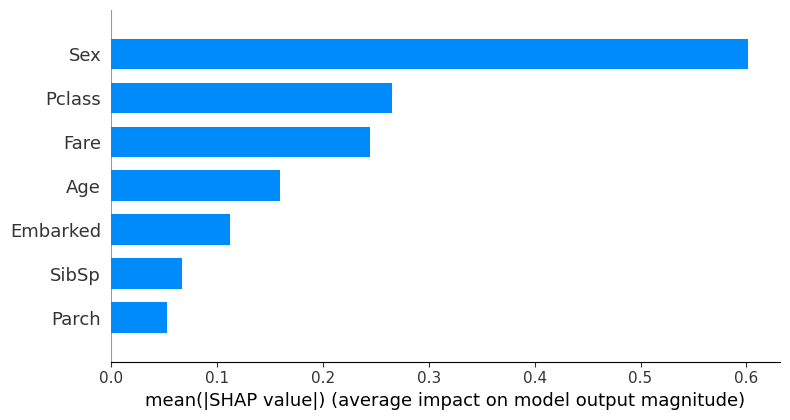

In [ ]:
shap.summary_plot(shap_values, df_test[FEATURES], plot_type="bar")

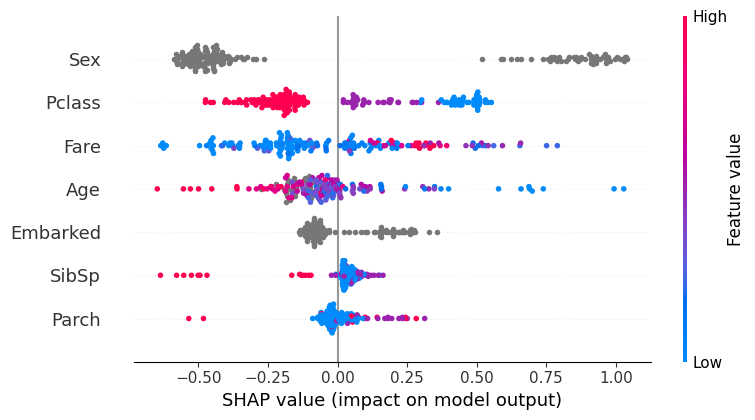

In [34]:
shap.summary_plot(shap_values, df_test[FEATURES])

## Feature selection

In [55]:
feat_imp_shap = pd.DataFrame({
    "feature": FEATURES,
    "importance": np.abs(shap_values).mean(0)
}).sort_values("importance", ascending=False)

feat_imp_shap

,feature,importance
5,Sex,0.601560
0,Pclass,0.265289
4,Fare,0.244975
1,Age,0.159478
6,Embarked,0.112857
2,SibSp,0.067164
3,Parch,0.052910


In [61]:
["None"] + feat_imp_shap.sort_values("importance").feature.to_list()[:-1]

['None', 'Parch', 'SibSp', 'Embarked', 'Age', 'Fare', 'Pclass']

In [62]:
FEATURES_KEEPED = FEATURES.copy()
results = {
    "feature_dropped": [],
    "auc": []
}

drop_ordered = ["None"] + feat_imp_shap.sort_values("importance").feature.to_list()[:-1]

for feat in drop_ordered:
    if feat != "None":
        FEATURES_KEEPED.remove(feat)

    results["feature_dropped"].append(feat)

    model = LGBMClassifier(**study.best_params, verbose=-1, random_state=23)
    model.fit(df_train[FEATURES_KEEPED], df_train[TARGET])

    pred = model.predict_proba(df_test[FEATURES_KEEPED])[:, 1]
    auc = roc_auc_score(df_test[TARGET], pred)
    
    results["auc"].append(auc)

results = pd.DataFrame(results)


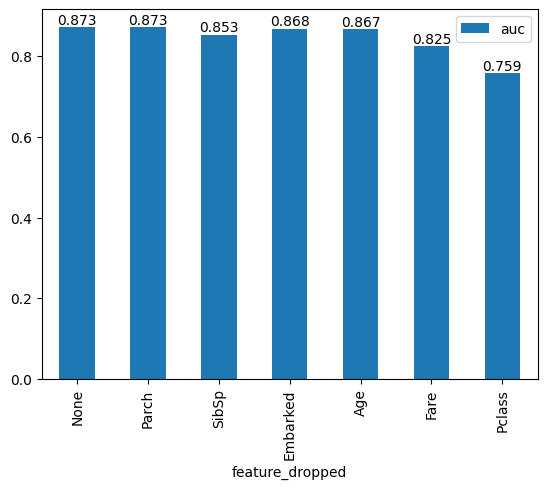

In [70]:
results.plot(kind="bar", x="feature_dropped", y="auc");
for i, v in enumerate(results.auc):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")